In [6]:
from IPython.display import display, Markdown
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', None)
df = pd.read_csv('results.csv')
df.head(5)

,id,submitdate,lastpage,startlanguage,seed,startdate,datestamp,consortium[berd],consortium[daphne4nfdi],consortium[dataplant],...,metadata[other],ontologies,sourcecode[none],sourcecode[private],sourcecode[gitlab],sourcecode[github],sourcecode[unsure],sourcecode[other],forward,contact
0,3,NaN,NaN,en,1373688864,2025-03-03 10:24:40,2025-03-03 10:24:40,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,NaN,2.0,en,1224941926,2025-03-03 10:27:47,2025-03-03 10:29:18,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,test,NaN,NaN
2,9,NaN,NaN,en,225193067,2025-03-03 11:16:45,2025-03-03 11:16:45,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,NaN,NaN,en,731973258,2025-03-03 11:17:30,2025-03-03 11:17:30,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,NaN,NaN,en,75363505,2025-03-03 11:17:37,2025-03-03 11:17:37,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df["startdate"] = pd.to_datetime(df["startdate"]).dt.date
date_series = df["startdate"].dropna()
mindate = date_series.min()
maxdate = date_series.max()
display("The "+str(len(df))+" survey responses were submitted between "+mindate.strftime('%d %B %Y')+" and "+maxdate.strftime('%d %B %Y')+".")

'The 113 survey responses were submitted between 03 March 2025 and 24 March 2025.'

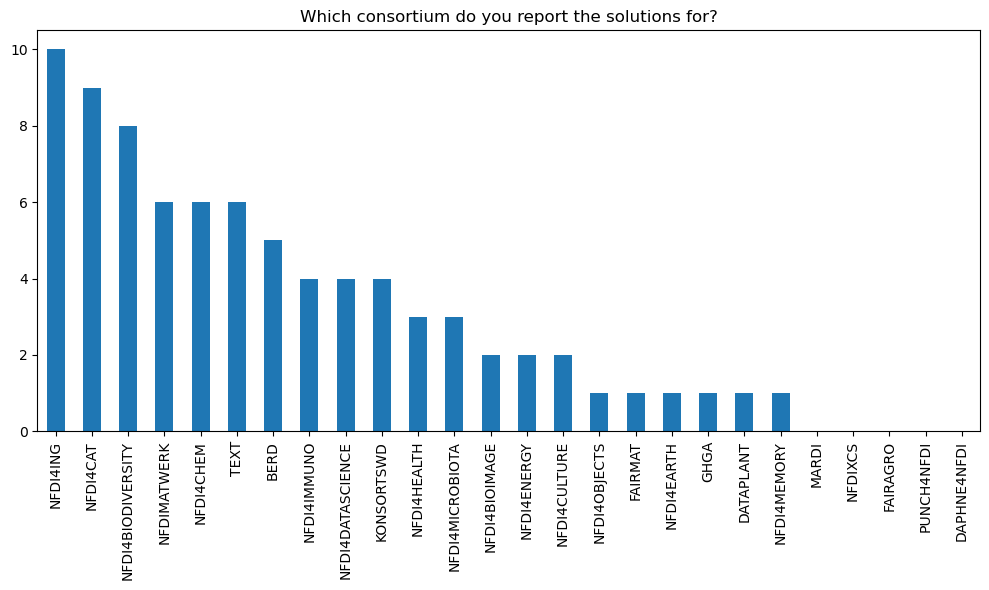

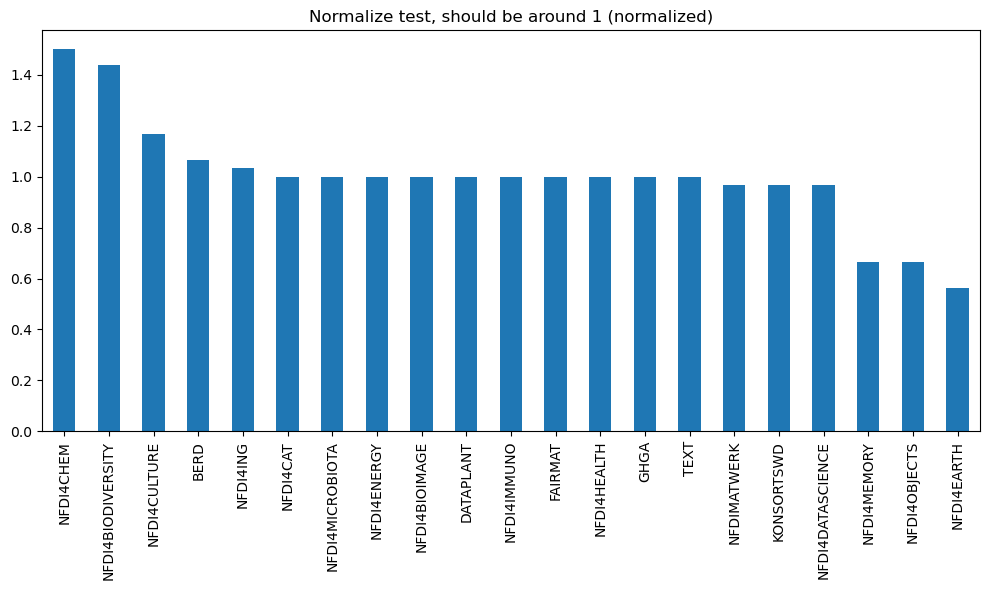

{'NFDI4CAT': 1.0000000000000002,
 'NFDI4MICROBIOTA': 1.0,
 'NFDI4EARTH': 0.5625,
 'NFDI4BIODIVERSITY': 1.4375,
 'NFDIMATWERK': 0.9666666666666666,
 'NFDI4ENERGY': 1.0,
 'TEXT': 0.9999999999999999,
 'BERD': 1.0666666666666667,
 'NFDI4BIOIMAGE': 1.0,
 'NFDI4CHEM': 1.5,
 'DATAPLANT': 1.0,
 'NFDI4ING': 1.0333333333333332,
 'NFDI4MEMORY': 0.6666666666666666,
 'NFDI4CULTURE': 1.1666666666666665,
 'NFDI4OBJECTS': 0.6666666666666666,
 'NFDI4IMMUNO': 1.0,
 'FAIRMAT': 1.0,
 'NFDI4HEALTH': 1.0,
 'KONSORTSWD': 0.9666666666666666,
 'GHGA': 1.0,
 'NFDI4DATASCIENCE': 0.9666666666666666}

In [51]:
def col_count(prefix,title):
    # prevent aggregate column from being aggregated with itself
    cols = {col for col in df.columns if isinstance(col, str) and col.startswith(prefix) and not "other" in col and not "comment" in col and col!=prefix}
    counts = {}
    df[prefix] = [set() for _ in range(len(df))]
    aggregate = df[prefix]
    for col in cols:
            # string type columns are mistakenly recognized as objects 
            df[col] = df[col].fillna('').astype(str)
            #display(df[col])
            new_col_name = re.sub(prefix+r"\[(.*)\]", lambda m: m.group(1).upper(), col)
            counts[new_col_name] = int((df[col] == 'Y').sum())
            named = df[col].replace('Y', new_col_name).astype(str)
            for index, _value in named.items():
                name = named.at[index]
                if name:
                     if not isinstance(name,str): 
                        display("Warning: name is not a string value : "+str(name))
         
            if new_col_name == 'OTHER':
                continue
            for index, _value in aggregate.items():
                cons = named.at[index]
                if cons:
                    if not isinstance(cons,str): 
                            display("Warning: consortium is not a string value : "+str(cons))
                            continue
                    if "{" in cons:
                        display("invalid character in consortium: '"+cons+"'")
                    #display("before",aggregate.at[index],"adding "+cons)
                    aggregate.at[index].add(cons)
                    #display("result:",aggregate.at[index])
    df[prefix] = aggregate
 
    sorted_counts  = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    #display(sorted_counts)
    pd.Series(sorted_counts).plot(kind='bar', figsize=(10, 6), rot=90, title=title)
    plt.tight_layout()
    plt.show()
    return sorted_counts

cons_count = col_count("consortium","Which consortium do you report the solutions for?")

#display(df["consortium"])

# normalization still in progress
def col_count_normalize(prefix,title):
    #cols = {col for col in df.columns if isinstance(col, str) and col.startswith(prefix)}
    counts = {}
    # aggregated consortium values created by calling col_count("consortium",...) first
    cons = df["consortium"]
    #display(cons)
    
    normalized_counts = {}
    aggregated = df[prefix]
    #for col in cols:
            #new_col_name = re.sub(prefix+r"\[(.*)\]", lambda m: m.group(1).upper(), col)
            #counts = int((df[col] == 'Y').sum())
    for index, values in aggregated.items():
            # using the aggregated column where the values are a set
            # alternatively we could also use the non-aggregated columns
            for value in values:
                if not value in normalized_counts:
                    normalized_counts[value] = 0
                consortia = cons.at[index]
                # ignore answers which did not specify a consortium, alternatively one could also assign a constant value to them
                if len(consortia)>0:
                    #display(consortia)
                    weights = list(map(lambda c: 1/cons_count[c],consortia))
                    weight = sum(weights)/len(weights)
                    normalized_counts[value] += weight

    sorted_counts  = dict(sorted(normalized_counts.items(), key=lambda item: item[1], reverse=True))
    pd.Series(sorted_counts).plot(kind='bar', figsize=(10, 6), rot=90, title=title+" (normalized)")
    plt.tight_layout()
    plt.show()
    return normalized_counts

# normalizing consoritium on itself does not produce helpful insights but we can verify that it works because the scores should all be 1 or close to it depending on how we treat special cases
col_count_normalize("consortium","Normalize test, should be around 1")

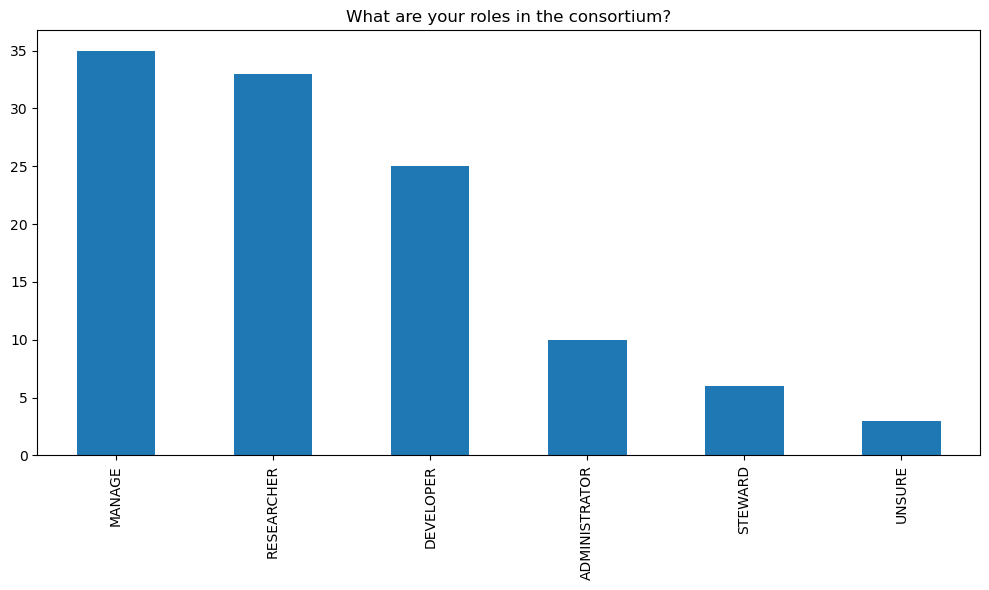

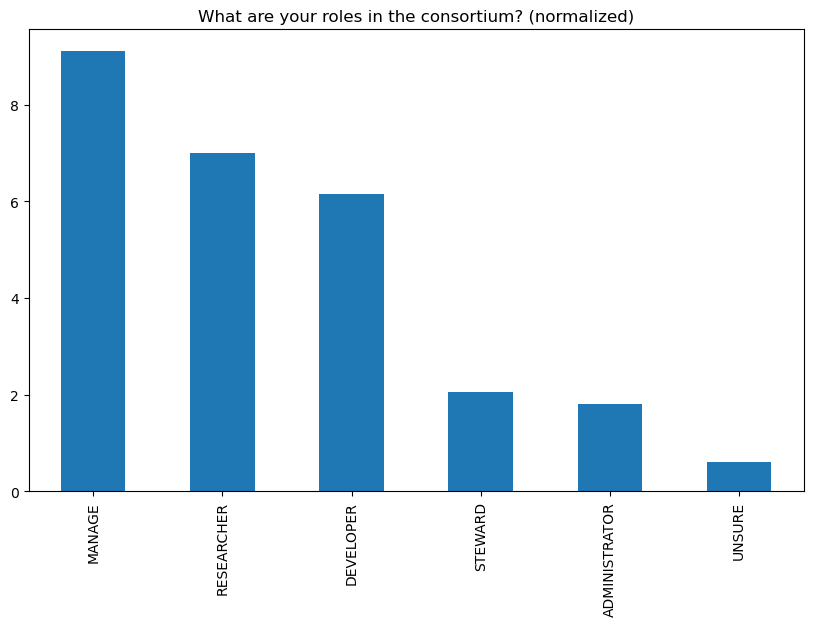

{'MANAGE': 9.102777777777778,
 'DEVELOPER': 6.143055555555556,
 'ADMINISTRATOR': 1.8055555555555558,
 'STEWARD': 2.0541666666666667,
 'RESEARCHER': 7.009722222222223,
 'UNSURE': 0.6}

In [46]:
col_count("role","What are your roles in the consortium?")
col_count_normalize("role","What are your roles in the consortium?")

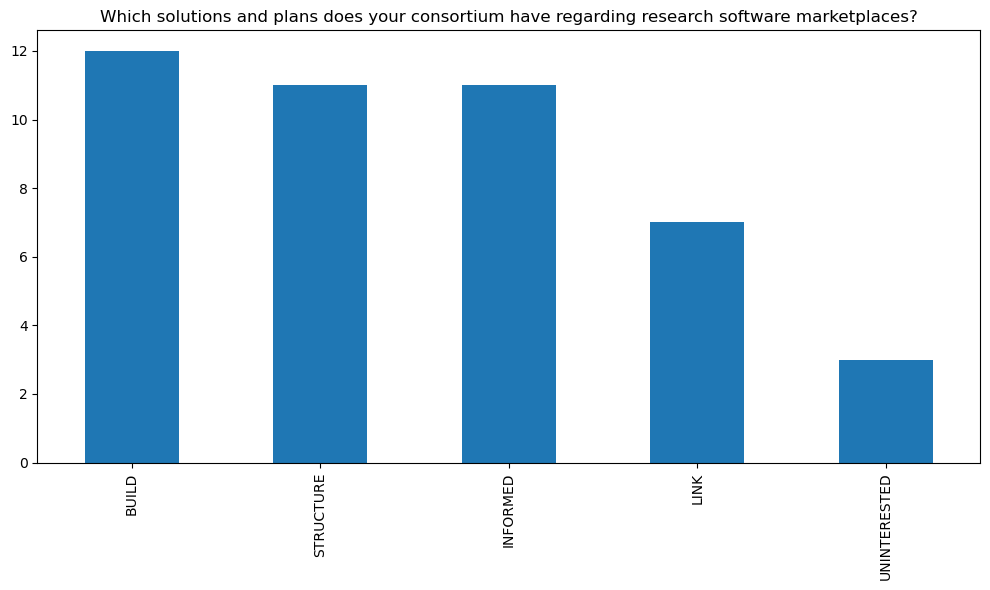

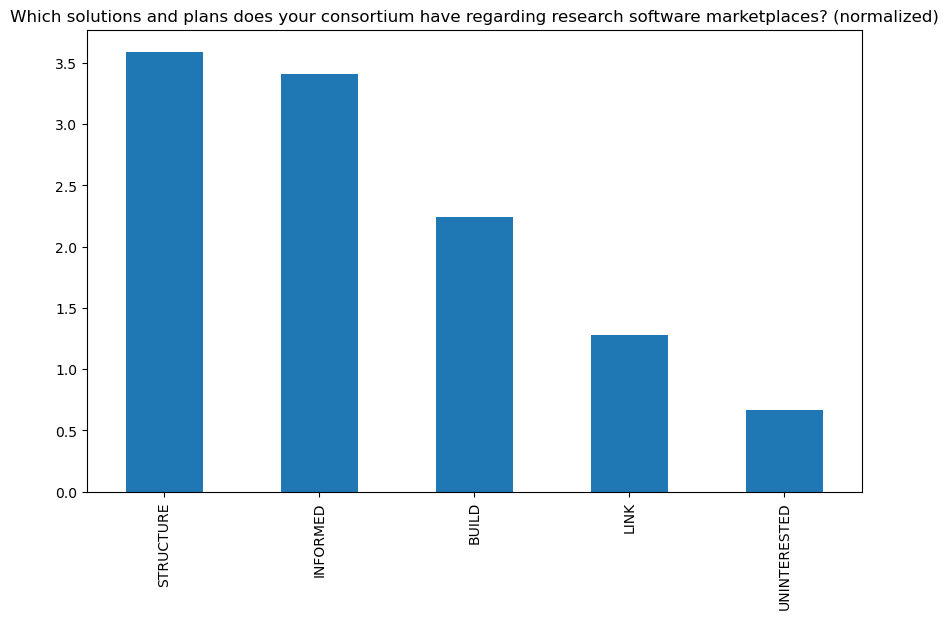

{'BUILD': 2.2416666666666667,
 'LINK': 1.277777777777778,
 'STRUCTURE': 3.591666666666667,
 'INFORMED': 3.4055555555555554,
 'UNINTERESTED': 0.6666666666666666}

In [47]:
col_count("solutions","Which solutions and plans does your consortium have regarding research software marketplaces?")
col_count_normalize("solutions","Which solutions and plans does your consortium have regarding research software marketplaces?")

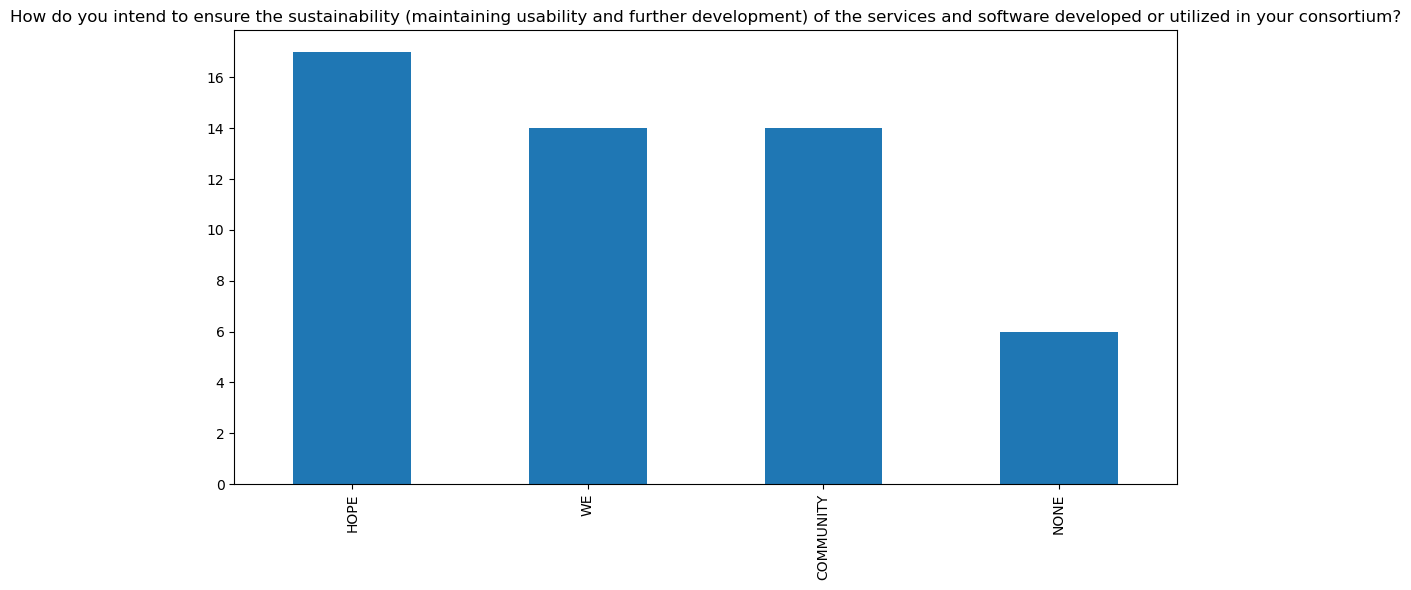

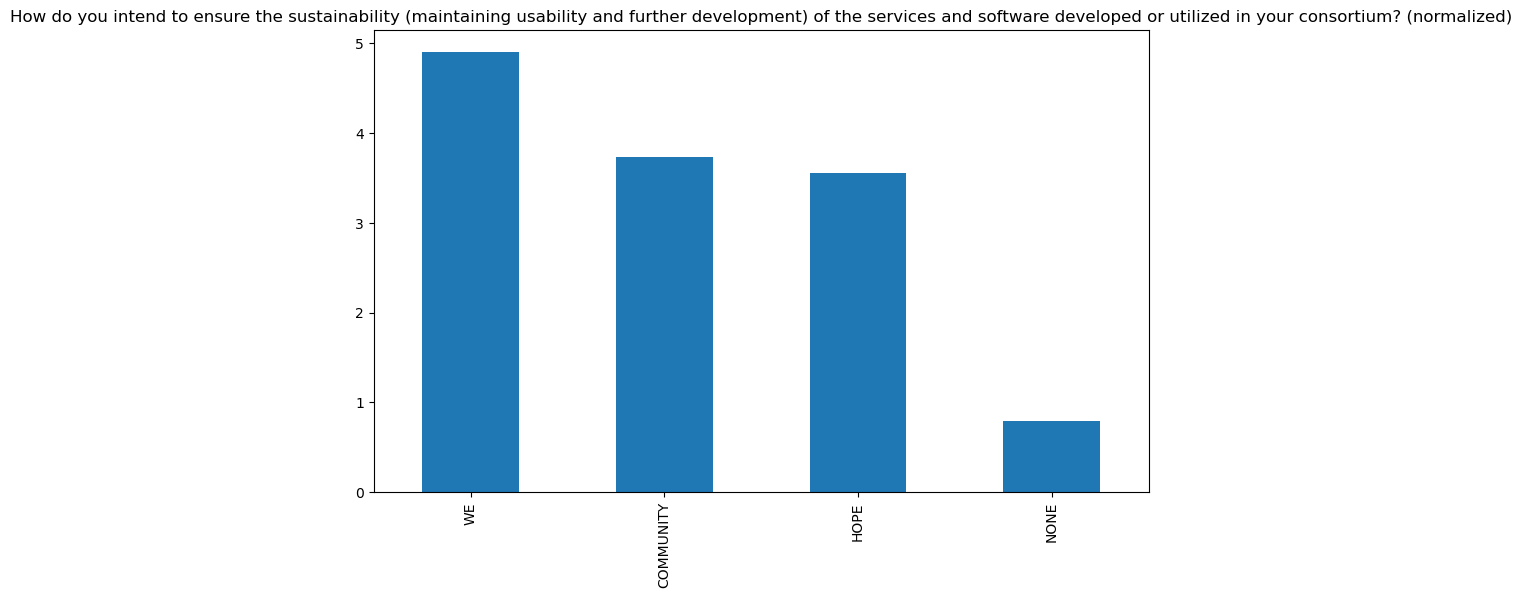

{'NONE': 0.7944444444444444,
 'COMMUNITY': 3.733333333333333,
 'WE': 4.902777777777778,
 'HOPE': 3.558333333333333}

In [50]:
col_count("sustain","How do you intend to ensure the sustainability (maintaining usability and further development) of the services and software developed or utilized in your consortium?")
col_count_normalize("sustain","How do you intend to ensure the sustainability (maintaining usability and further development) of the services and software developed or utilized in your consortium?")

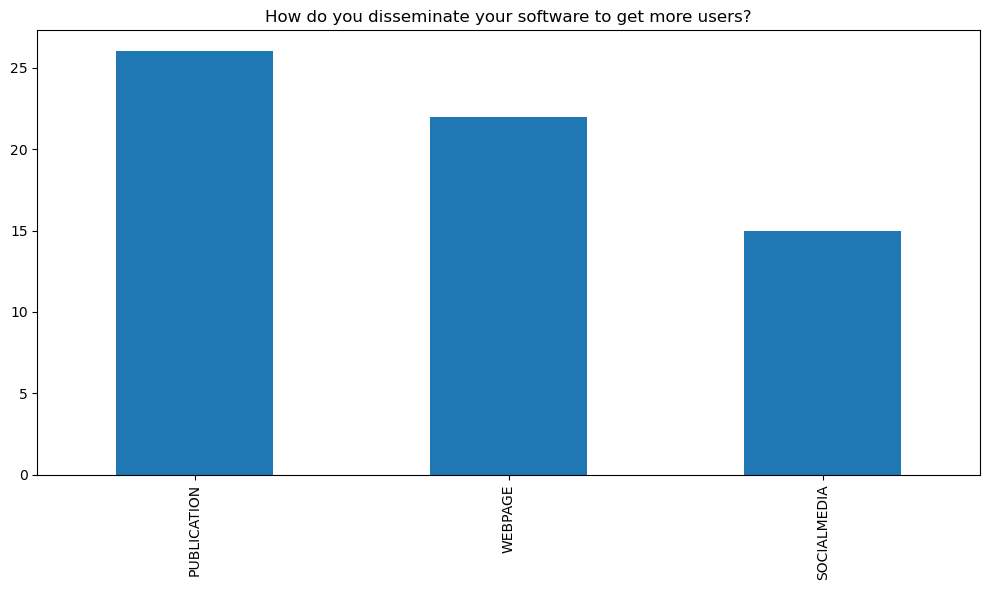

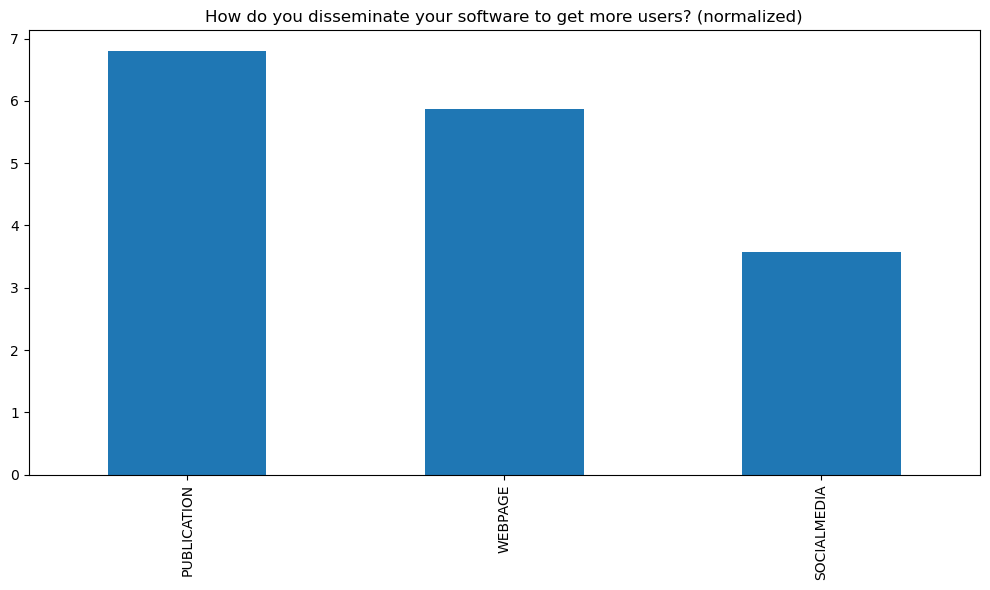

{'PUBLICATION': 6.791666666666667,
 'SOCIALMEDIA': 3.566666666666667,
 'WEBPAGE': 5.875}

In [52]:
col_count("disseminate","How do you disseminate your software to get more users?")
col_count_normalize("disseminate","How do you disseminate your software to get more users?")

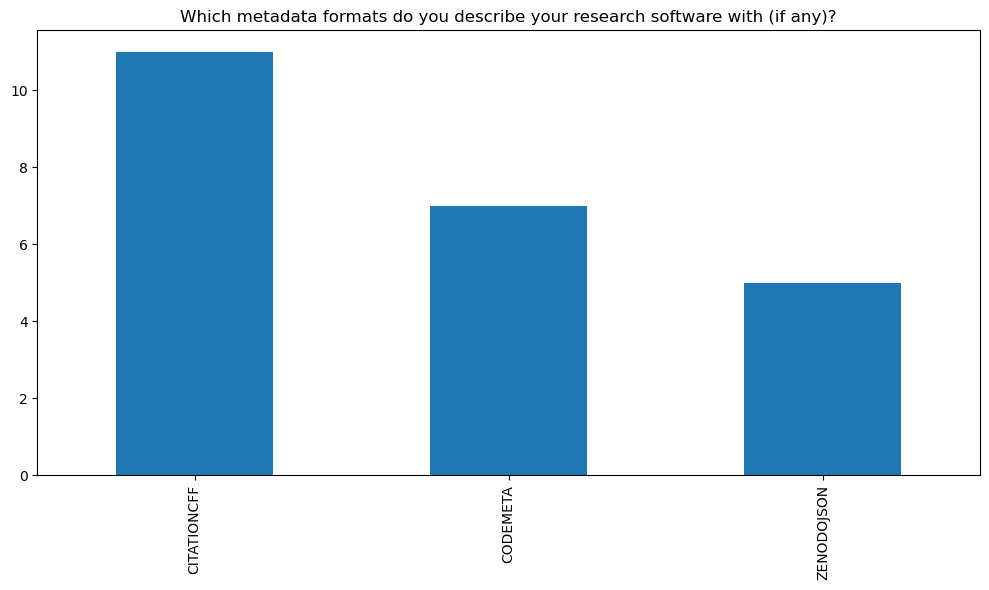

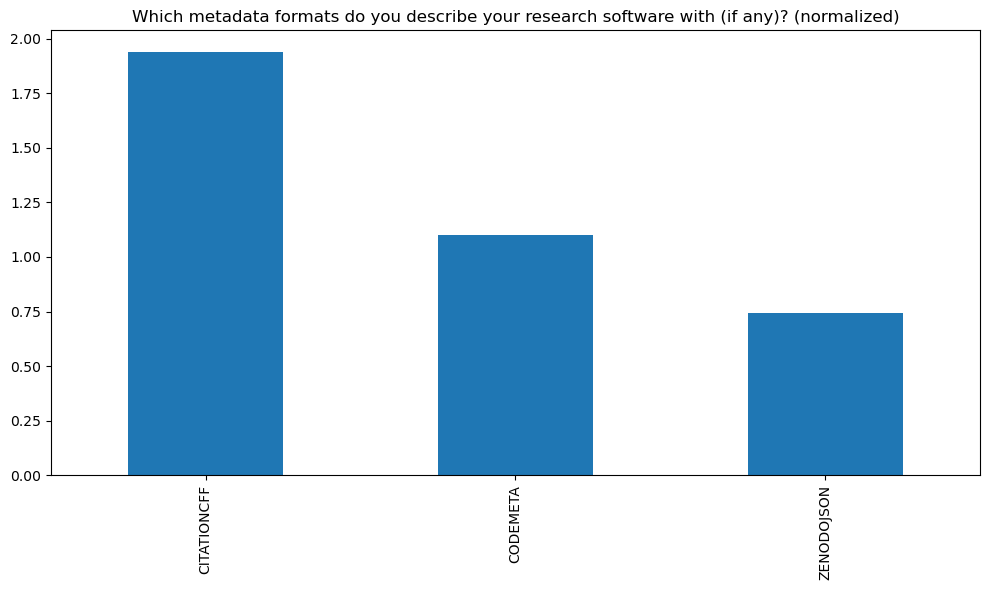

{'ZENODOJSON': 0.7444444444444444,
 'CITATIONCFF': 1.9416666666666669,
 'CODEMETA': 1.1}

In [53]:
col_count("metadata","Which metadata formats do you describe your research software with (if any)?")
col_count_normalize("metadata","Which metadata formats do you describe your research software with (if any)?")

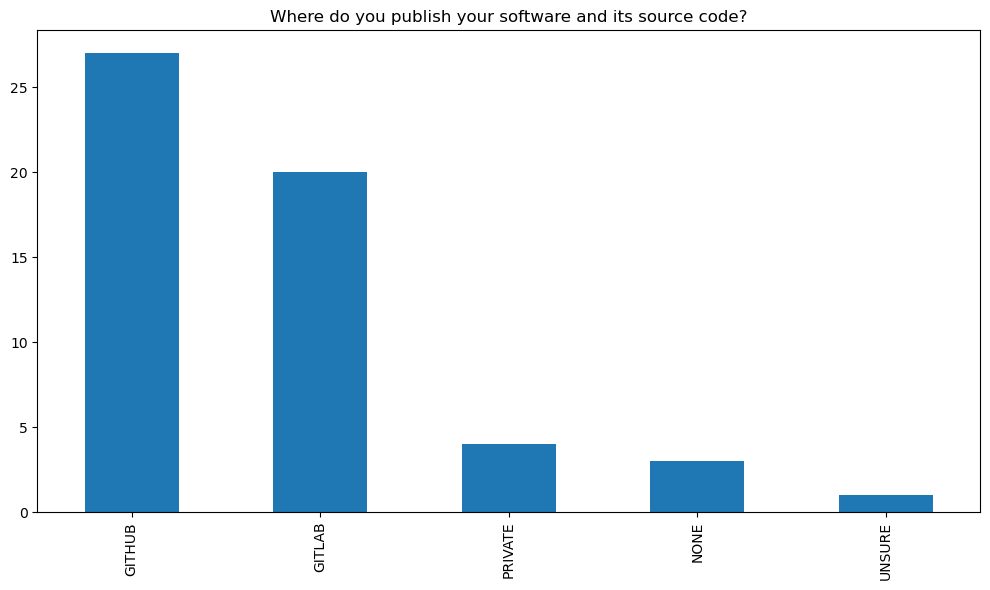

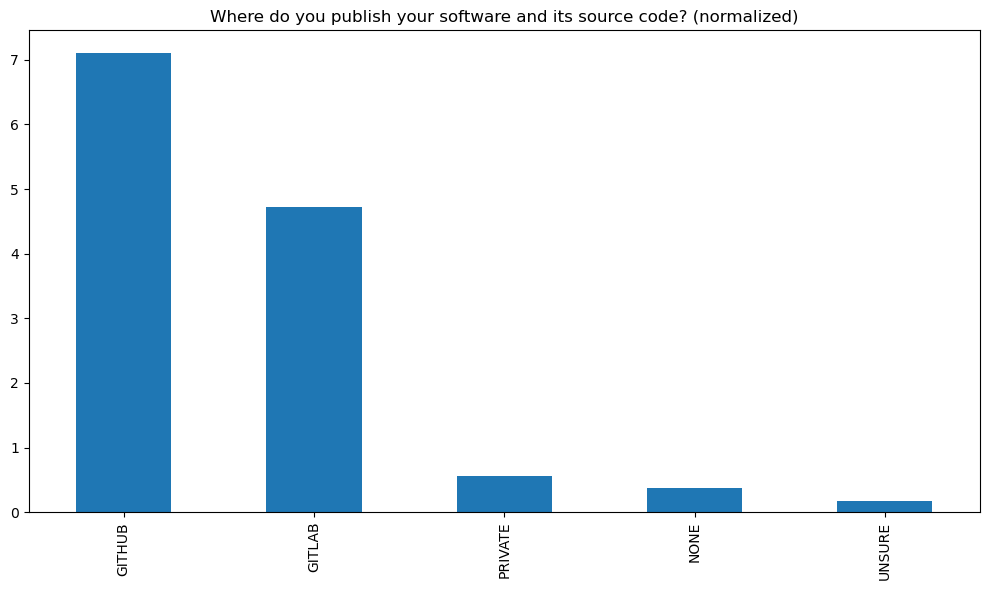

{'GITHUB': 7.1000000000000005,
 'PRIVATE': 0.5583333333333333,
 'GITLAB': 4.722222222222222,
 'NONE': 0.375,
 'UNSURE': 0.16666666666666666}

In [54]:
col_count("sourcecode","Where do you publish your software and its source code?")
col_count_normalize("sourcecode","Where do you publish your software and its source code?")

The problem with all those answers is that they are strongly biased by different participation ranging from 0 to 11 answers per consortium.
Thus we also look into the normalized values.
Ideally, there should be identical answers within each consortium but we suspect this won't be the case in practise, so we also look at the differences.
However the non-normalized values also shouldn't be discounted because if we assume participation is correlated with consortium size (or expressed in another way the probability of answering is not correlated by the consortium), then we can just treat the non-normalized values as samples from the whole of NFDI and the answers as based on the individual practises.
For example, if Persons A and B both belong to consortium C, and A answers GitHub and B answers GitLab to the source code question, then this doesn't need to mean that one got the answer wrong, just that there is no single answer that is valid for all people in that consortium.